# Catalog Tools: How To

<div class="alert alert-block alert-info">
    
#### In this notebook we will show how to:

<ol>
    <li>Download catalogs</li>
    <li>Generate synthetic earthquakes</li>
    <li>Bin magnitudes</li>
    <li>Calculate b-values</li>
</ol>

## 0. Import general packages and catalog tools
<font color=#208de2> In the main package, the analytic tools are available (b-value estimation), while other funcitons as catalog downloads, general functions and plotting are defined as subpackages. </font>

In [1]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


# catalog tools

# analysis
from catalog_tools import estimate_beta_elst
from catalog_tools import estimate_beta_utsu
from catalog_tools import estimate_beta_tinti
from catalog_tools import estimate_beta_laplace

# download
from catalog_tools import download_catalog_sed
from catalog_tools import prepare_sed_catalog

# plots
from catalog_tools import plot_cum_fmd
from catalog_tools import plot_fmd

# utils
from catalog_tools import bin_to_precision
from catalog_tools import simulate_magnitudes

## 1. Download catalog

<font color=#208de2> Swiss Catalog. Start date and end date have to be defined as a datetime. </font>

In [2]:
start_time = pd.to_datetime('2022/01/01')
end_time = dt.datetime.now()
min_magnitude = 0.5

df = download_catalog_sed(start_time=start_time, end_time=end_time, min_magnitude=min_magnitude)
df = prepare_sed_catalog(df, convert_to_mw=False)

<font color=#208de2> The output is a dataframe: </font>

In [3]:
df.tail()

,#EventID,time,latitude,longitude,depth,Author,Catalog,Contributor,ContributorID,mag_type,magnitude,MagAuthor,EventLocationName,event_type
9,smi:ch.ethz.sed/sc20a/Event/2023dtioae,2023-02-23 00:31:45.056920,46.336013,7.396939,3.7,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023dtioae,MLhc,0.8,mesimeri@sc20ag,Sanetschpass VS,earthquake
5,smi:ch.ethz.sed/sc20a/Event/2023duovgs,2023-02-23 16:45:40.837885,45.681640,7.651130,2.4,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023duovgs,MLhc,1.0,mesimeri@sc20ag,Aosta I,earthquake
4,smi:ch.ethz.sed/sc20a/Event/2023dvmnnd,2023-02-24 04:40:48.801935,46.669902,10.498199,6.6,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023dvmnnd,MLhc,1.0,mesimeri@sc20ag,Santa Maria GR,earthquake
1,smi:ch.ethz.sed/sc20a/Event/2023dxsozb,2023-02-25 09:52:30.835399,46.319181,7.345715,3.5,toni@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023dxsozb,MLhc,1.1,toni@sc20ag,Sanetschpass VS,earthquake
0,smi:ch.ethz.sed/sc20a/Event/2023dyygcc,2023-02-26 01:47:41.006636,47.899909,8.828153,11.0,toni@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023dyygcc,MLhc,1.0,toni@sc20ag,Tuttlingen D,earthquake


<font color=#208de2> We can plot the cumulative frequency-magnitude distribution (FMD): </font>

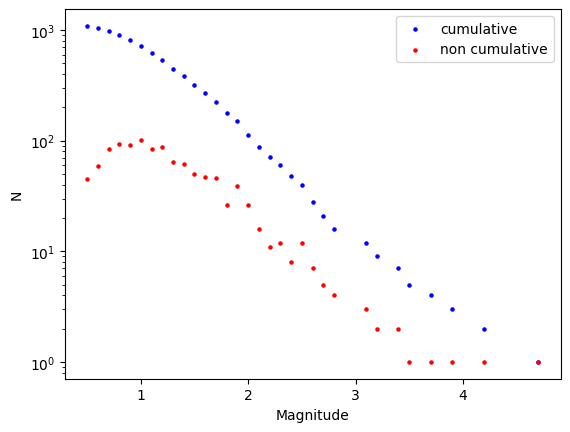

In [4]:
font = {'size': 10}
matplotlib.rc('font', **font)
ax = plt.subplots()[1]
plot_cum_fmd(df['magnitude'], ax=ax, color='blue')
plot_fmd(df['magnitude'], ax=ax, color='red')

ax.legend(['cumulative', 'non cumulative'])

## 2. Generate synthetic earthquakes
<font color=#208de2> First we need to define the number of earthquakes, the b-value and the completeness magnitude. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value. </font>

In [5]:
n = 200
b_value = 1
beta = b_value*np.log(10)
delta_m = 0.1
mc = 3
mc_generation = mc - delta_m / 2

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [6]:
mags = simulate_magnitudes(n,beta,mc_generation)

## 3. Bin magnitudes
<font color=#208de2> In order to bin the magnitudes, we just need to define the step-size: </font>

In [7]:
mags_binned = bin_to_precision(mags, delta_m)

## 4. Calculate b-values
<font color=#208de2> We estimate the b-value from the binned sample. It is important to pass on the information of which binning (if any) is applied. Also, be cautious that beta is (as above) a factor of np.log(10) different to the b-value. </font>

In [8]:
beta_estimate = estimate_beta_tinti(mags_binned, mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_utsu(mags_binned,mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_elst(mags_binned, delta_m=delta_m)
# beta_estimate = estimate_beta_laplace(mags_binned, delta_m=delta_m)

<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that the data are offset by half the binning size so that the cumulative number is shown correctly. </font>

/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_12786/351548141.py:8: UserWarning: The label '_' of <matplotlib.collections.PathCollection object at 0x1331c0400> starts with '_'. It is thus excluded from the legend.
  ax.legend(['Magnitudes original', 'True b-value', '_', 'Fit Tinti'])


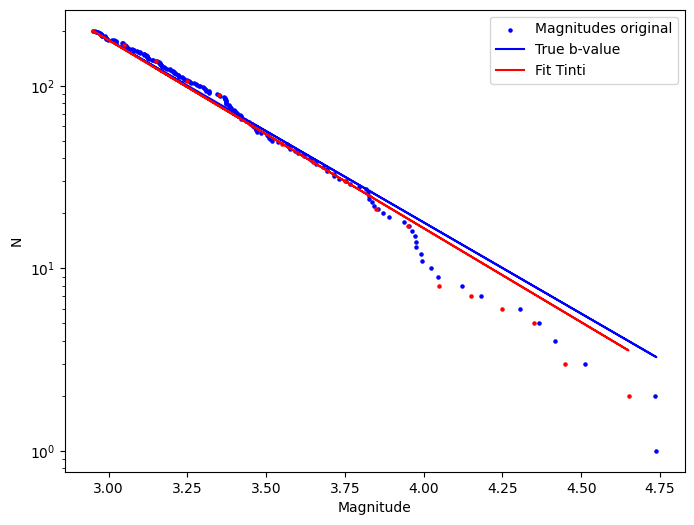

In [9]:
font = {'size': 10}
matplotlib.rc('font', **font)
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(mags, ax=ax, b_value=b_value, mc=mc - delta_m/2, color='blue')
plot_cum_fmd(mags_binned,ax=ax, b_value=beta_estimate/np.log(10), delta_m=delta_m, color='red')

ax.legend(['Magnitudes original', 'True b-value', '_', 'Fit Tinti'])

In [10]:
from catalog_tools.plots.basics import plot_cum_count, plot_mags_in_time, plot_in_space

In [11]:
start_time = pd.to_datetime('2018/01/01')
end_time = dt.datetime.now()
min_magnitude = 0.5

df2 = download_catalog_sed(start_time=start_time, end_time=end_time, min_magnitude=min_magnitude)
df2 = prepare_sed_catalog(df2, convert_to_mw=False)

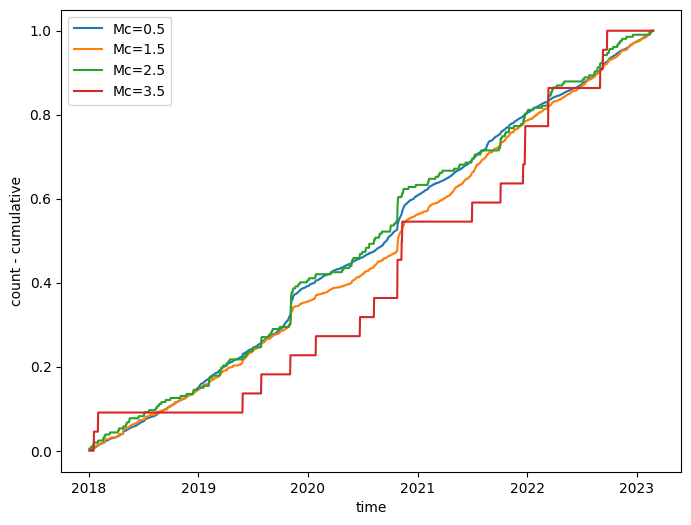

In [12]:
ax = plt.subplots(figsize=(8, 6))[1]
plot_cum_count(ax, df2, mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

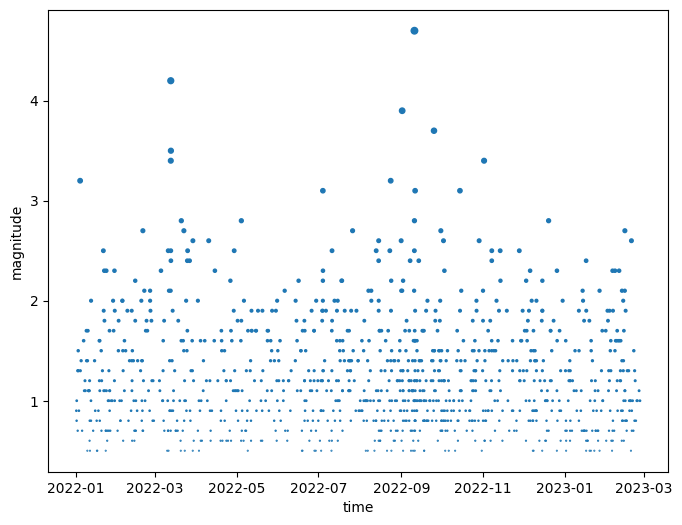

In [13]:
ax = plt.subplots(figsize=(8, 6))[1]
plot_mags_in_time(ax, df)

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

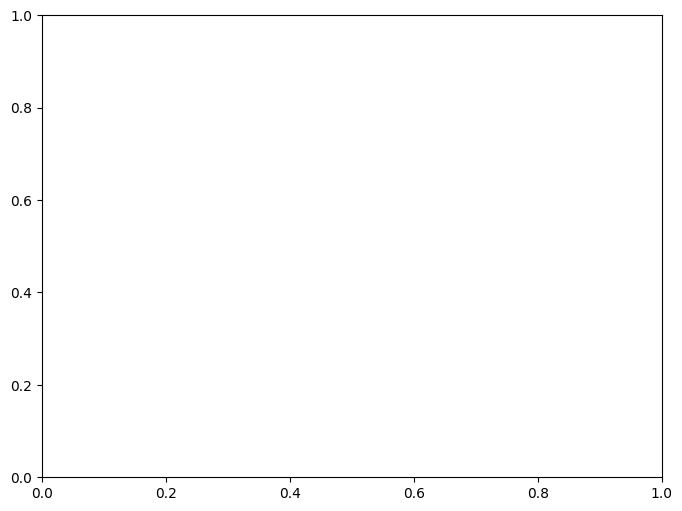

In [14]:
ax = plt.subplots(figsize=(8, 6))[1]
plot_in_space(ax, df2)

In [16]:
import obspy
obspy.imaging.maps.plot_cartopy

ModuleNotFoundError: No module named 'obspy'